## Classification Model for Colorado

In [1]:
# packages used
import pandas as pd
import numpy as np
from sklearn import tree
#from sklearn.ensemble import BaggingClassifier
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

In [2]:
%run ./graph_counts.py

In [3]:
# Load the data
data_dir = 'Data/'
Stores = pd.read_csv(data_dir + 'AllStoresColorado.csv', dtype = str)
StoreType = pd.read_csv(data_dir + 'NonLowPointStoresColorado.csv', dtype = str)
Stores.head()

,RTL_STORE_CD,RTL_FIPS_COUNTY_DSC,RTL_PREMISE_TYPE_CD,RTL_CHANNEL_DSC,RTL_SUBCHANNEL_DSC,RTL_BEER_FLAG,RTL_LIQUOR_FLG
0,100194153,ADAMS,OFF,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,Y,N
1,102147363,DENVER,OFF,LIQUOR,CONVENTIONAL LIQUOR,Y,Y
2,107506920,ADAMS,ON,BAR/NIGHTCLUB,PREMIUM BAR,Y,Y
3,100543468,BOULDER,OFF,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,Y,N
4,101853786,DENVER,ON,DINING,CASUAL DINING,Y,Y


In [4]:
StoreType.head()

,RTL_STORE_CD,BEERTYPE
0,101424017,NonLowPoint
1,101397465,NonLowPoint
2,101915274,NonLowPoint
3,101424090,NonLowPoint
4,107473829,NonLowPoint


In [5]:
FullData = pd.merge(Stores, StoreType, on="RTL_STORE_CD", how="left")

In [6]:
FullData.loc[FullData['BEERTYPE'].isnull(),"BEERTYPE"] = "LowPoint"

In [7]:
FullData = pd.concat([FullData, pd.get_dummies(FullData['RTL_FIPS_COUNTY_DSC'],prefix='COUNTY')], axis=1)
FullData = pd.concat([FullData, pd.get_dummies(FullData['RTL_PREMISE_TYPE_CD'],prefix='PREMISE')], axis=1)
FullData = pd.concat([FullData, pd.get_dummies(FullData['RTL_CHANNEL_DSC'],prefix='CHANNEL')], axis=1)
FullData = pd.concat([FullData, pd.get_dummies(FullData['RTL_SUBCHANNEL_DSC'],prefix='SUBCHANNEL')], axis=1)
FullData = pd.concat([FullData, pd.get_dummies(FullData['RTL_BEER_FLAG'],prefix='BEER_LICENSE')], axis=1)
FullData = pd.concat([FullData, pd.get_dummies(FullData['RTL_LIQUOR_FLG'],prefix='LIQUOR_LICENSE')], axis=1)
FullData.head()

,RTL_STORE_CD,RTL_FIPS_COUNTY_DSC,RTL_PREMISE_TYPE_CD,RTL_CHANNEL_DSC,RTL_SUBCHANNEL_DSC,RTL_BEER_FLAG,RTL_LIQUOR_FLG,BEERTYPE,COUNTY_ADAMS,COUNTY_ALAMOSA,...,SUBCHANNEL_SUPERMARKET-CONVENTIONAL,SUBCHANNEL_SUPERMARKET-NATURAL/GOURMET FOODS,SUBCHANNEL_THEATER,SUBCHANNEL_THEME PARK,SUBCHANNEL_WINE SPECIALTY STORE,SUBCHANNEL_WINERIES/VINEYARDS,BEER_LICENSE_N,BEER_LICENSE_Y,LIQUOR_LICENSE_N,LIQUOR_LICENSE_Y
0,100194153,ADAMS,OFF,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,Y,N,LowPoint,1,0,...,0,0,0,0,0,0,0,1,1,0
1,102147363,DENVER,OFF,LIQUOR,CONVENTIONAL LIQUOR,Y,Y,NonLowPoint,0,0,...,0,0,0,0,0,0,0,1,0,1
2,107506920,ADAMS,ON,BAR/NIGHTCLUB,PREMIUM BAR,Y,Y,NonLowPoint,1,0,...,0,0,0,0,0,0,0,1,0,1
3,100543468,BOULDER,OFF,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,Y,N,LowPoint,0,0,...,0,0,0,0,0,0,0,1,1,0
4,101853786,DENVER,ON,DINING,CASUAL DINING,Y,Y,NonLowPoint,0,0,...,0,0,0,0,0,0,0,1,0,1


## Business Rules

In [8]:
FullData['LowPoint_Y'] = ""

In [10]:
def Rules_Corolado(dataframe):
    for row in range(len(dataframe)):
        if dataframe.loc[row,'RTL_PREMISE_TYPE_CD'] == 'OFF':
            if dataframe.loc[row,'RTL_CHANNEL_DSC'] == 'LIQUOR' or dataframe.loc[row,'RTL_CHANNEL_DSC'] == 'DRUG' or dataframe.loc[row,'RTL_CHANNEL_DSC'] == 'MILITARY OFF-PREMISE':
                dataframe.loc[row,'LowPoint_Y'] = False
            elif dataframe.loc[row,'RTL_CHANNEL_DSC'] == 'GROCERY':
                if dataframe.loc[row,'RTL_LIQUOR_FLG'] == 'Y':
                    dataframe.loc[row,'LowPoint_Y'] = False
                else:
                    dataframe.loc[row,'LowPoint_Y'] = True
            else:
                dataframe.loc[row,'LowPoint_Y'] = True
        else:
             dataframe.loc[row,'LowPoint_Y'] = False
    return dataframe

#save the Corolado business rule into pickle
pickle.dump(Rules_Corolado, open('Corolado_business_rule.p', 'wb'))

In [11]:
Corolado_rule_func = pickle.load(open('Corolado_business_rule.p', 'rb'))

result_df = Corolado_rule_func(FullData)
result_df.head()

,RTL_STORE_CD,RTL_FIPS_COUNTY_DSC,RTL_PREMISE_TYPE_CD,RTL_CHANNEL_DSC,RTL_SUBCHANNEL_DSC,RTL_BEER_FLAG,RTL_LIQUOR_FLG,BEERTYPE,COUNTY_ADAMS,COUNTY_ALAMOSA,...,SUBCHANNEL_SUPERMARKET-NATURAL/GOURMET FOODS,SUBCHANNEL_THEATER,SUBCHANNEL_THEME PARK,SUBCHANNEL_WINE SPECIALTY STORE,SUBCHANNEL_WINERIES/VINEYARDS,BEER_LICENSE_N,BEER_LICENSE_Y,LIQUOR_LICENSE_N,LIQUOR_LICENSE_Y,LowPoint_Y
0,100194153,ADAMS,OFF,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,Y,N,LowPoint,1,0,...,0,0,0,0,0,0,1,1,0,True
1,102147363,DENVER,OFF,LIQUOR,CONVENTIONAL LIQUOR,Y,Y,NonLowPoint,0,0,...,0,0,0,0,0,0,1,0,1,False
2,107506920,ADAMS,ON,BAR/NIGHTCLUB,PREMIUM BAR,Y,Y,NonLowPoint,1,0,...,0,0,0,0,0,0,1,0,1,False
3,100543468,BOULDER,OFF,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,Y,N,LowPoint,0,0,...,0,0,0,0,0,0,1,1,0,True
4,101853786,DENVER,ON,DINING,CASUAL DINING,Y,Y,NonLowPoint,0,0,...,0,0,0,0,0,0,1,0,1,False


# Business Rules result

In [19]:
# Confusion Matrix
cm = confusion_matrix(FullData['BEERTYPE'], FullData['PREDICTION'])
cm

array([[1277,   55],
       [  80, 6263]])

In [20]:
#Accuracy
Accuracy = (cm[0,0] + cm[1,1])/ np.sum(cm)
Accuracy

0.98241042345276874

In [21]:
#check how many stores are predicted wrong; which are they; what characters do they have
error_index_list = []
for index in range(len(FullData)):
    if FullData.ix[index , 'BEERTYPE'] != FullData.ix[index , 'PREDICTION']:
        error_index_list.append(index)
print('there are', len(error_index_list), 'errors in the prediction')

there are 135 errors in the prediction


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  after removing the cwd from sys.path.


In [22]:
#check the error predictions
error_df = FullData.ix[error_index_list, ]
false_NonLowPoint = error_df.loc[error_df['BEERTYPE'] == 'LowPoint']
print('there are', len(false_NonLowPoint), 'false_NonLowPoint errors.')
false_NonLowPoint.head()

there are 55 false_NonLowPoint errors.


,RTL_STORE_CD,RTL_FIPS_COUNTY_DSC,RTL_PREMISE_TYPE_CD,RTL_CHANNEL_DSC,RTL_SUBCHANNEL_DSC,RTL_BEER_FLAG,RTL_LIQUOR_FLG,BEERTYPE,COUNTY_ADAMS,COUNTY_ALAMOSA,...,SUBCHANNEL_SUPERMARKET-NATURAL/GOURMET FOODS,SUBCHANNEL_THEATER,SUBCHANNEL_THEME PARK,SUBCHANNEL_WINE SPECIALTY STORE,SUBCHANNEL_WINERIES/VINEYARDS,BEER_LICENSE_N,BEER_LICENSE_Y,LIQUOR_LICENSE_N,LIQUOR_LICENSE_Y,PREDICTION
13,201951429,WELD,ON,BAR/NIGHTCLUB,NEIGHBORHOOD BAR,Y,Y,LowPoint,0,0,...,0,0,0,0,0,0,1,0,1,NonLowPoint
183,101803253,JEFFERSON,ON,DINING,CASUAL DINING,Y,Y,LowPoint,0,0,...,0,0,0,0,0,0,1,0,1,NonLowPoint
257,102601870,EL PASO,ON,LODGING,FULL SERVICE LODGING,Y,N,LowPoint,0,0,...,0,0,0,0,0,0,1,1,0,NonLowPoint
339,101955165,EL PASO,ON,RECREATION,PRIVATE CLUB,Y,Y,LowPoint,0,0,...,0,0,0,0,0,0,1,0,1,NonLowPoint
416,107487739,DENVER,ON,DINING,CASUAL DINING,Y,Y,LowPoint,0,0,...,0,0,0,0,0,0,1,0,1,NonLowPoint


In [23]:
false_LowPoint = error_df.loc[error_df['BEERTYPE'] == 'NonLowPoint']
print('there are', len(false_LowPoint), 'false_LowPoint errors.')
false_LowPoint.head()

there are 80 false_LowPoint errors.


,RTL_STORE_CD,RTL_FIPS_COUNTY_DSC,RTL_PREMISE_TYPE_CD,RTL_CHANNEL_DSC,RTL_SUBCHANNEL_DSC,RTL_BEER_FLAG,RTL_LIQUOR_FLG,BEERTYPE,COUNTY_ADAMS,COUNTY_ALAMOSA,...,SUBCHANNEL_SUPERMARKET-NATURAL/GOURMET FOODS,SUBCHANNEL_THEATER,SUBCHANNEL_THEME PARK,SUBCHANNEL_WINE SPECIALTY STORE,SUBCHANNEL_WINERIES/VINEYARDS,BEER_LICENSE_N,BEER_LICENSE_Y,LIQUOR_LICENSE_N,LIQUOR_LICENSE_Y,PREDICTION
19,100996359,ARCHULETA,OFF,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,Y,N,NonLowPoint,0,0,...,0,0,0,0,0,0,1,1,0,LowPoint
51,200713864,BOULDER,OFF,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,Y,N,NonLowPoint,0,0,...,0,0,0,0,0,0,1,1,0,LowPoint
68,100663846,DENVER,OFF,EXTENDED MASTER OFF-PREMISE,OTHER OFF-PREMISE,N,N,NonLowPoint,0,0,...,0,0,0,0,0,1,0,1,0,LowPoint
72,200638465,CLEAR CREEK,OFF,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,Y,N,NonLowPoint,0,0,...,0,0,0,0,0,0,1,1,0,LowPoint
253,101991144,ADAMS,OFF,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,Y,N,NonLowPoint,1,0,...,0,0,0,0,0,0,1,1,0,LowPoint


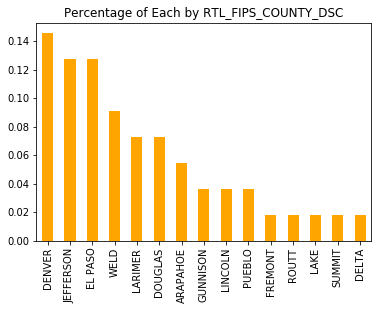

In [24]:
#create false_NonLowPoint by County
graph_counts(false_NonLowPoint, 'RTL_FIPS_COUNTY_DSC', False, 'bar', True, 15)

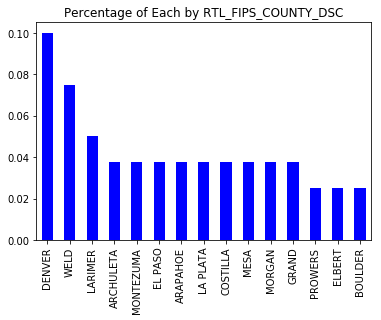

In [25]:
#create false_LowPoint by County
graph_counts(false_LowPoint, 'RTL_FIPS_COUNTY_DSC', False, 'bar', True, 15)

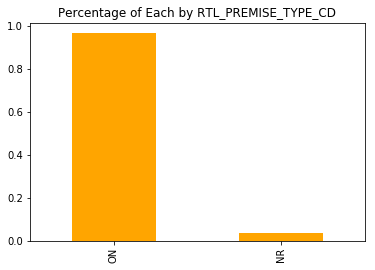

In [26]:
#create false_NonLowPoint by premise type
graph_counts(false_NonLowPoint, 'RTL_PREMISE_TYPE_CD', False, 'bar', True, 15)

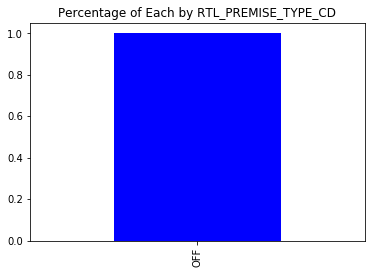

In [27]:
#create false_LowPoint by premise type
graph_counts(false_LowPoint, 'RTL_PREMISE_TYPE_CD', False, 'bar', True, 15)

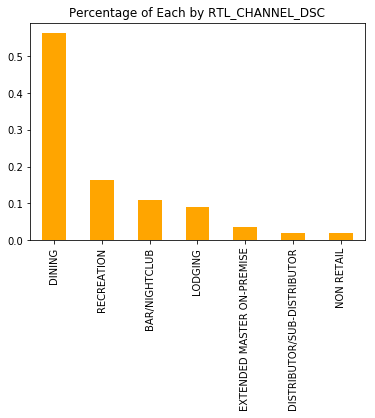

In [28]:
#create false_NonLowPoint by Channel
graph_counts(false_NonLowPoint, 'RTL_CHANNEL_DSC', False, 'bar', True, 15)

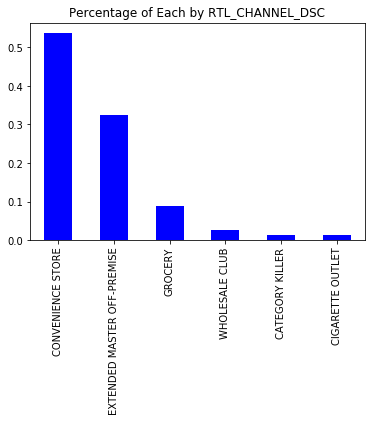

In [29]:
#create false_LowPoint by Channel
graph_counts(false_LowPoint, 'RTL_CHANNEL_DSC', False, 'bar', True, 15)

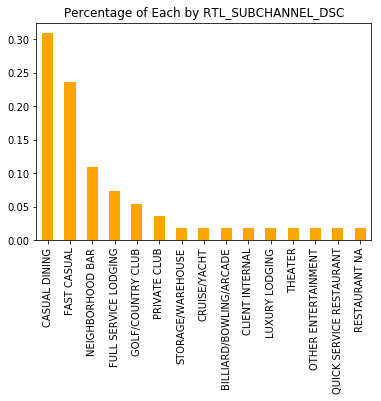

In [30]:
#create false_NonLowPoint by sub channel
graph_counts(false_NonLowPoint, 'RTL_SUBCHANNEL_DSC', False, 'bar', True, 15)

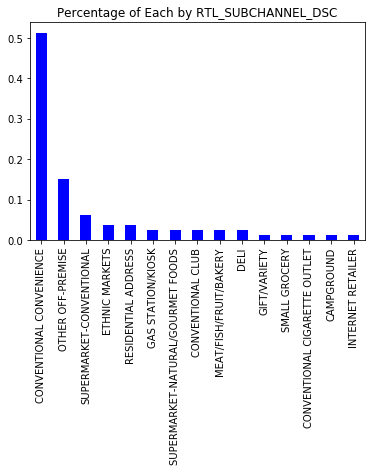

In [31]:
#create false_LowPoint by sub channel
graph_counts(false_LowPoint, 'RTL_SUBCHANNEL_DSC', False, 'bar', True, 15)

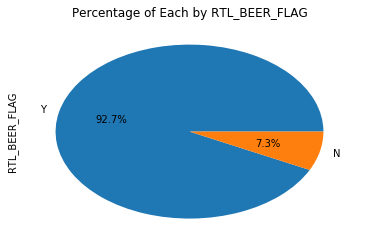

In [32]:
#create false_NonLowPoint by Beer License
graph_counts(false_NonLowPoint, 'RTL_BEER_FLAG', False, 'pie', True, 15)

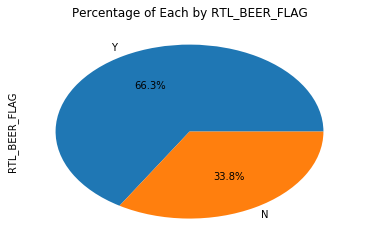

In [33]:
#create false_LowPoint by Beer License
graph_counts(false_LowPoint, 'RTL_BEER_FLAG', False, 'pie', True, 15)

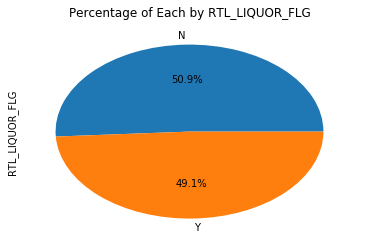

In [34]:
#create false_NonLowPoint by Liquor License
graph_counts(false_NonLowPoint, 'RTL_LIQUOR_FLG', False, 'pie', True, 15)

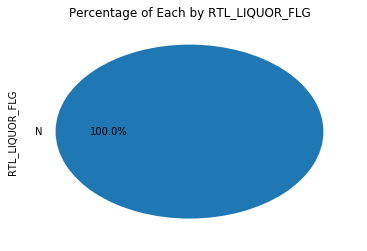

In [35]:
#create false_LowPoint by Liquor License
graph_counts(false_LowPoint, 'RTL_LIQUOR_FLG', False, 'pie', True, 15)

In [36]:
FullData.head()

,RTL_STORE_CD,RTL_FIPS_COUNTY_DSC,RTL_PREMISE_TYPE_CD,RTL_CHANNEL_DSC,RTL_SUBCHANNEL_DSC,RTL_BEER_FLAG,RTL_LIQUOR_FLG,BEERTYPE,COUNTY_ADAMS,COUNTY_ALAMOSA,...,SUBCHANNEL_SUPERMARKET-NATURAL/GOURMET FOODS,SUBCHANNEL_THEATER,SUBCHANNEL_THEME PARK,SUBCHANNEL_WINE SPECIALTY STORE,SUBCHANNEL_WINERIES/VINEYARDS,BEER_LICENSE_N,BEER_LICENSE_Y,LIQUOR_LICENSE_N,LIQUOR_LICENSE_Y,PREDICTION
0,100194153,ADAMS,OFF,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,Y,N,LowPoint,1,0,...,0,0,0,0,0,0,1,1,0,LowPoint
1,102147363,DENVER,OFF,LIQUOR,CONVENTIONAL LIQUOR,Y,Y,NonLowPoint,0,0,...,0,0,0,0,0,0,1,0,1,NonLowPoint
2,107506920,ADAMS,ON,BAR/NIGHTCLUB,PREMIUM BAR,Y,Y,NonLowPoint,1,0,...,0,0,0,0,0,0,1,0,1,NonLowPoint
3,100543468,BOULDER,OFF,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,Y,N,LowPoint,0,0,...,0,0,0,0,0,0,1,1,0,LowPoint
4,101853786,DENVER,ON,DINING,CASUAL DINING,Y,Y,NonLowPoint,0,0,...,0,0,0,0,0,0,1,0,1,NonLowPoint


### Decision Tree Approach

In [ ]:
# prepare data to fit model
X_labels = [c for c in FullData.columns if c not in ['RTL_STORE_CD','BEERTYPE','RTL_FIPS_COUNTY_DSC','RTL_PREMISE_TYPE_CD','RTL_CHANNEL_DSC','RTL_SUBCHANNEL_DSC','RTL_BEER_FLAG',"RTL_LIQUOR_FLG", "PREDICTION"]]
X = FullData.loc[:,X_labels]
Y = FullData['BEERTYPE']

In [ ]:
parameters = {'max_depth':range(1,21), 'min_samples_leaf':range(3,21,3), 'min_samples_split':range(3,21,3), 'random_state': [0]}
clf = tree.DecisionTreeClassifier()
clf = GridSearchCV(clf, parameters, n_jobs = -2)
clf.fit(X, Y)
best_params = clf.best_params_
best_params

{'max_depth': 3,
 'min_samples_leaf': 9,
 'min_samples_split': 3,
 'random_state': 0}

# Decision Tree Result

In [ ]:
#the result: with the best tree depth and accuracy
best_depth = best_params['max_depth']
best_leaf = best_params['min_samples_leaf']
best_split = best_params['min_samples_split']
accuracy = clf.best_score_ 

print('the best depth is:', best_depth, 'with minimium leaf =',best_leaf , 'minimium split =',best_split, 'with accuracy:',round(accuracy*100, 3), '%')

the best depth is: 3 with minimium leaf = 9 minimium split = 3 with accuracy: 98.41 %


In [ ]:
#check the errors:

#create a new data frame to store the prediction result. 
result_df = FullData.loc[:, 'RTL_STORE_CD': 'BEERTYPE']
result_df['PRED_RESULT'] = clf.predict(X)
result_df.head()

,RTL_STORE_CD,RTL_FIPS_COUNTY_DSC,RTL_PREMISE_TYPE_CD,RTL_CHANNEL_DSC,RTL_SUBCHANNEL_DSC,RTL_BEER_FLAG,RTL_LIQUOR_FLG,BEERTYPE,PRED_RESULT
0,100194153,ADAMS,OFF,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,Y,N,LowPoint,LowPoint
1,102147363,DENVER,OFF,LIQUOR,CONVENTIONAL LIQUOR,Y,Y,NonLowPoint,NonLowPoint
2,107506920,ADAMS,ON,BAR/NIGHTCLUB,PREMIUM BAR,Y,Y,NonLowPoint,NonLowPoint
3,100543468,BOULDER,OFF,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,Y,N,LowPoint,LowPoint
4,101853786,DENVER,ON,DINING,CASUAL DINING,Y,Y,NonLowPoint,NonLowPoint


In [ ]:
#check how many stores are predicted wrong; which are they; what characters do they have
error_index_list = []
for index in range(len(result_df)):
    if result_df.ix[index , 'BEERTYPE'] != result_df.ix[index , 'PRED_RESULT']:
        error_index_list.append(index)
print('there are', len(error_index_list), 'errors in the prediction')

there are 122 errors in the prediction


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  after removing the cwd from sys.path.


In [ ]:
#check the error predictions
error_df = result_df.ix[error_index_list, ]
false_NonLowPoint = error_df.loc[error_df['BEERTYPE'] == 'LowPoint']
false_LowPoint = error_df.loc[error_df['BEERTYPE'] == 'NonLowPoint']
print('there are', len(false_NonLowPoint), 'false_NonLowPoint errors.')
print('there are', len(false_LowPoint), 'false_LowPoint errors.')
false_NonLowPoint.head()

there are 67 false_NonLowPoint errors.
there are 55 false_LowPoint errors.


,RTL_STORE_CD,RTL_FIPS_COUNTY_DSC,RTL_PREMISE_TYPE_CD,RTL_CHANNEL_DSC,RTL_SUBCHANNEL_DSC,RTL_BEER_FLAG,RTL_LIQUOR_FLG,BEERTYPE,PRED_RESULT
13,201951429,WELD,ON,BAR/NIGHTCLUB,NEIGHBORHOOD BAR,Y,Y,LowPoint,NonLowPoint
183,101803253,JEFFERSON,ON,DINING,CASUAL DINING,Y,Y,LowPoint,NonLowPoint
257,102601870,EL PASO,ON,LODGING,FULL SERVICE LODGING,Y,N,LowPoint,NonLowPoint
339,101955165,EL PASO,ON,RECREATION,PRIVATE CLUB,Y,Y,LowPoint,NonLowPoint
416,107487739,DENVER,ON,DINING,CASUAL DINING,Y,Y,LowPoint,NonLowPoint


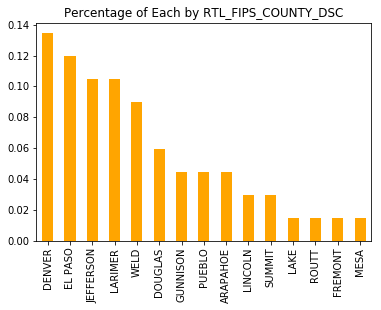

In [ ]:
#create false_NonLowPoint by County
graph_counts(false_NonLowPoint, 'RTL_FIPS_COUNTY_DSC', False, 'bar', True, 15)

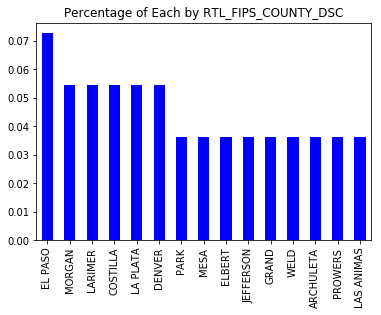

In [ ]:
#create false_LowPoint by County
graph_counts(false_LowPoint, 'RTL_FIPS_COUNTY_DSC', False, 'bar', True, 15)

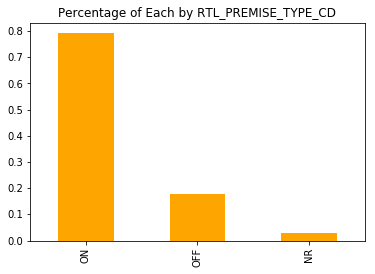

In [ ]:
#create false_NonLowPoint by premise type
graph_counts(false_NonLowPoint, 'RTL_PREMISE_TYPE_CD', False, 'bar', True, 15)

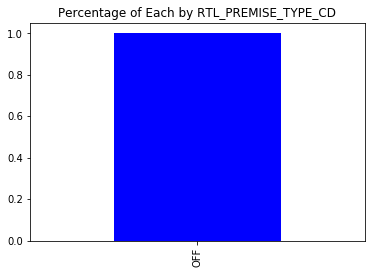

In [ ]:
#create false_LowPoint by premise type
graph_counts(false_LowPoint, 'RTL_PREMISE_TYPE_CD', False, 'bar', True, 15)

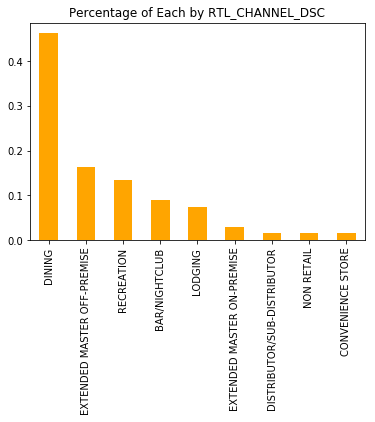

In [ ]:
#create false_NonLowPoint by Channel
graph_counts(false_NonLowPoint, 'RTL_CHANNEL_DSC', False, 'bar', True, 15)

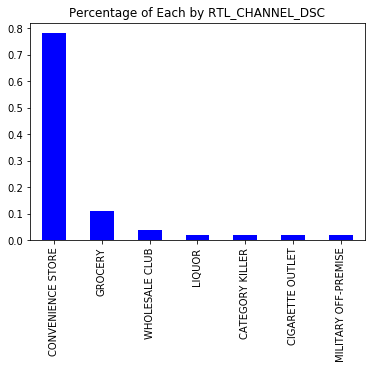

In [ ]:
#create false_LowPoint by Channel
graph_counts(false_LowPoint, 'RTL_CHANNEL_DSC', False, 'bar', True, 15)

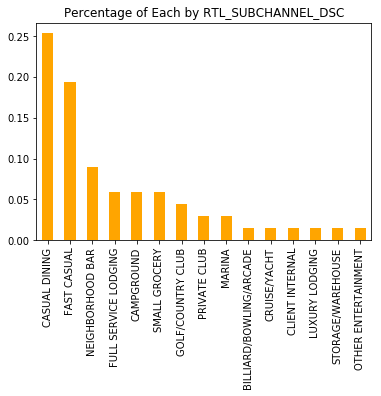

In [ ]:
#create false_NonLowPoint by sub channel
graph_counts(false_NonLowPoint, 'RTL_SUBCHANNEL_DSC', False, 'bar', True, 15)

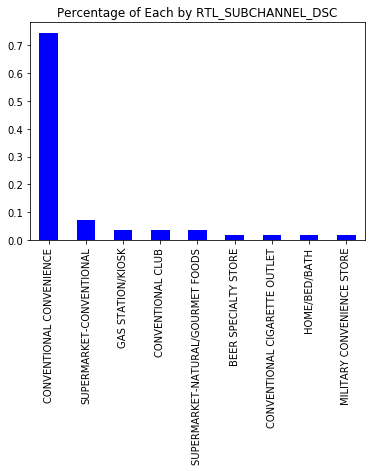

In [ ]:
#create false_LowPoint by sub channel
graph_counts(false_LowPoint, 'RTL_SUBCHANNEL_DSC', False, 'bar', True, 15)

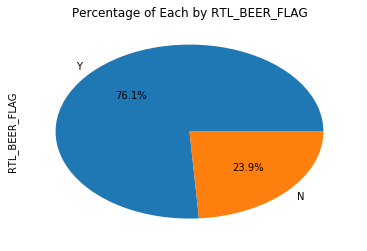

In [ ]:
#create false_NonLowPoint by Beer License
graph_counts(false_NonLowPoint, 'RTL_BEER_FLAG', False, 'pie', True, 15)

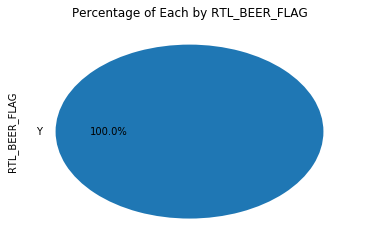

In [ ]:
#create false_LowPoint by Beer License
graph_counts(false_LowPoint, 'RTL_BEER_FLAG', False, 'pie', True, 15)

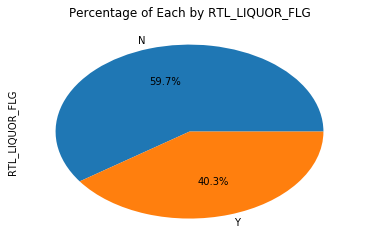

In [ ]:
#create false_NonLowPoint by Liquor License
graph_counts(false_NonLowPoint, 'RTL_LIQUOR_FLG', False, 'pie', True, 15)

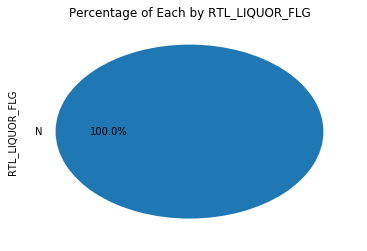

In [ ]:
#create false_LowPoint by Liquor License
graph_counts(false_LowPoint, 'RTL_LIQUOR_FLG', False, 'pie', True, 15)

In [ ]:
#feature importance
clf = tree.DecisionTreeClassifier(max_depth=best_depth, min_samples_leaf= best_leaf, min_samples_split = best_split, random_state=0)
clf = clf.fit(X,Y)

#all the features with their importance scores.
feature_score = pd.Series(data=clf.feature_importances_, index=X.columns).sort_values(ascending = False)

#only show the features that have scores greater than 0
feature_score[feature_score > 0]


LIQUOR_LICENSE_Y                       0.767341
PREMISE_OFF                            0.214147
BEER_LICENSE_N                         0.017022
SUBCHANNEL_CASUAL DINING               0.001347
SUBCHANNEL_QUICK SERVICE RESTAURANT    0.000104
SUBCHANNEL_LUXURY LODGING              0.000040
dtype: float64

In [ ]:
# Confusion Matrix
cm = confusion_matrix(result_df['BEERTYPE'], result_df['PRED_RESULT'])
cm

array([[1265,   67],
       [  55, 6288]])

In [ ]:
# True Positive Rate
TPR = cm[1,1]/(cm[1,1]+cm[1,0])
TPR

0.99132902412107837

In [ ]:
# False Negative Rate
FNR = cm[1,0]/(cm[1,0]+cm[1,1])
FNR

0.0086709758789216464

In [ ]:
# True Negative Rate
TNR = cm[0,0]/(cm[0,0]+cm[0,1])
TNR

0.9496996996996997

In [ ]:
# False Positive Rate
FPR = cm[0,1]/(cm[0,1]+cm[0,0])
FPR

0.050300300300300298